# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository. The first three columns denote different parameters obtained from the photographs of the banknotes and last colum provides the label. Frankly as the dataset does not have any description I don't know  which labels corresponds to real and which to counterfeited banknotes. let's assume that label one (positive) denotes the clounterfeits. The set  "banknote_authentication.csv" can be found in the data  directory.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scrapbook as sb

/home/gosia/.local/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [4]:
data = pd.read_csv('data/banknote_authentication.csv')

In [5]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. Please use `scrapbook` to store your results. 

In [6]:
from sklearn.model_selection import train_test_split
seed =5657
data_train, data_test = train_test_split(data, test_size = 0.4, stratify = data['counterfeit'], random_state = seed)

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(data_train.loc[:, "a1":"a3"], data_train ['counterfeit'])

QuadraticDiscriminantAnalysis()

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score
test_proba = qda.predict_proba(data_test.loc[:, "a1":"a3"])[:,1]

In [9]:
confusion_matrix(data_test['counterfeit'], test_proba>0.5,normalize='true')

array([[0.81147541, 0.18852459],
       [0.17948718, 0.82051282]])

In [10]:
f1_score(data_test['counterfeit'], test_proba > 0.5)

0.7980049875311721

In [11]:
sb.glue('A_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc']

also please save the ROC plot

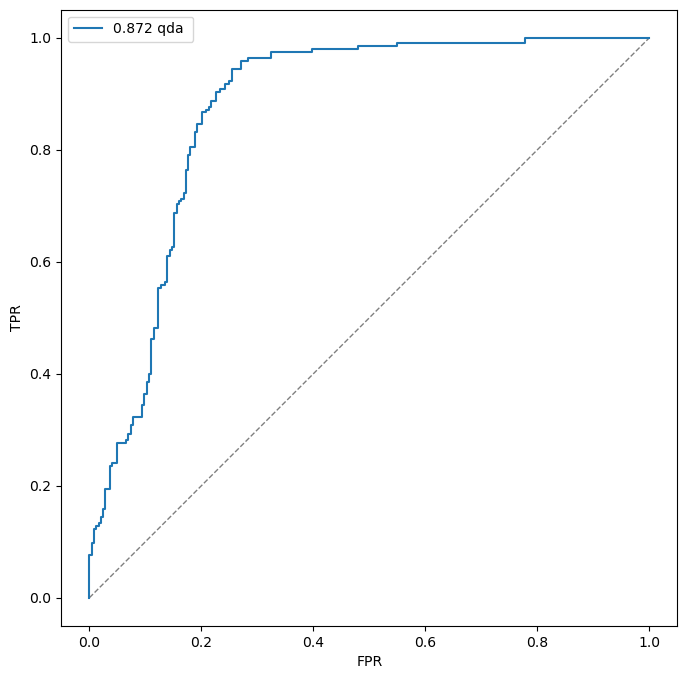

In [12]:
#plot ROC
from mchlearn.plotting import roc_plot, add_roc_curve
fig, ax = roc_plot()
add_roc_curve(data_test['counterfeit'], test_proba, name='qda', ax=ax)
ax.legend()
sb.glue('A_ROC',fig, "display", display=True);


### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

In [13]:
sb.glue('B_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc']

In [14]:
train_r = data_train[data_train['counterfeit']==0].loc[:,'a1':'a3']
train_c = data_train[data_train['counterfeit']==1].loc[:,'a1':'a3']

In [15]:
from sklearn.mixture import GaussianMixture
gm_r = GaussianMixture(n_components = 2)
gm_c = GaussianMixture(n_components = 2)

In [16]:
gm_r.fit(train_r)
gm_c.fit(train_c)

GaussianMixture(n_components=2)

In [17]:
def make_pdf(cmp):
    """
    Takes a GaussianMixture object and returns corresponding
    probability distribution function
    """
    n_cmp = cmp.n_components
    dists = [st.multivariate_normal(cmp.means_[i], cmp.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= cmp.weights_[i]*dists[i].pdf(x)
        return p
    
    return pdf
    
    
def make_predict_proba(cmp0, cmp1, pi0=0.5, pi1=.5):
    """
    Takes two GaussianMixture object and corresponding priors and returns 
    pdf for conditional probability P(c=1|x)
    """
    pdf0 = make_pdf(cmp0)
    pdf1 = make_pdf(cmp1)
    def p(x):
        p0=pi0*pdf0(x)
        p1=pi1*pdf1(x)
        return p1/(p1+p0)    
        
    return p
        

In [18]:
mgda = make_predict_proba(gm_r, gm_c, pi1=0.44)
mgda_test_proba = mgda(data_test.loc[:, 'a1':'a3'])

In [19]:
confusion_matrix(data_test['counterfeit'], mgda_test_proba>0.5)

array([[228,  16],
       [ 32, 163]])

In [20]:
f1_score(data_test['counterfeit'], mgda_test_proba>0.5)

0.8716577540106951

also please save the ROC plot

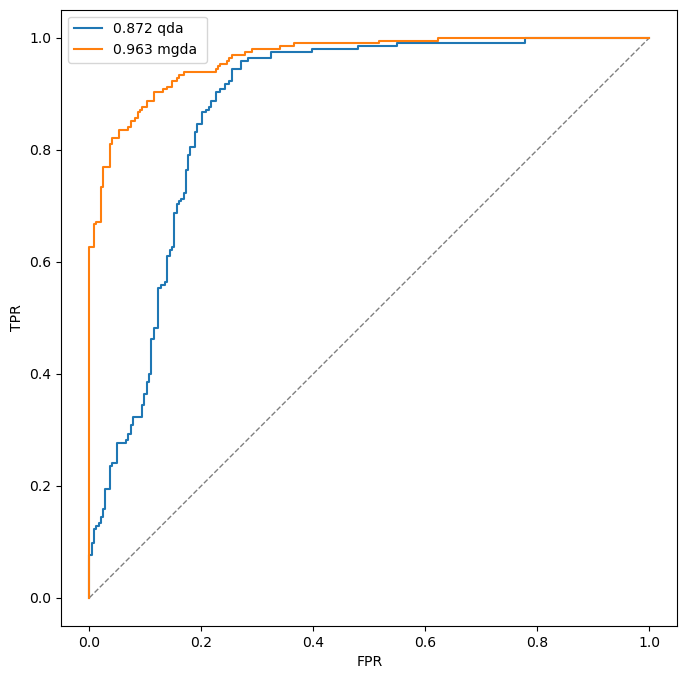

In [21]:
fig, ax = roc_plot()
add_roc_curve(data_test['counterfeit'], test_proba, name='qda', ax=ax)
add_roc_curve(data_test['counterfeit'], mgda_test_proba, name='mgda', ax=ax)
ax.legend()
sb.glue('B_ROC',fig, "display", display=True);

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. 

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

In [42]:
import functools

def run(n_cmp0, n_cmp1, train, test, pi):
    gm0 = GaussianMixture(n_components=n_cmp0)
    gm1 = GaussianMixture(n_components=n_cmp1)
    gm0.fit(train[train[:,-1]==0][:,:-1])
    gm1.fit(train[train[:,-1]==1][:,:-1])
    mpp = make_predict_proba(gm0, gm1, pi1=pi)
    proba_test = mpp(test[:,:-1])
    return f1_score(test[:,-1], proba_test>0.5)

In [45]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True)
n_range = (1, 30)
nl = n_range[1] - n_range[0]
mat = np.zeros((nl,nl))
for n0 in range(*n_range):
    print(n0)
    for n1 in range(*n_range):
        f1 = 0.0
        for train_index, test_index in skf.split(data_train.loc[:, 'a1':'a3'], data_train['counterfeit']):
            f1 += run(n0, n1, data_train.values[train_index][:,1:], data_train.values[test_index][:,1:], 0.5)
        mat[n0-n_range[0], n1-n_range[0]] = f1/5

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Store the results for the best estimator

In [ ]:
sb.glue('C_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

also please save the ROC plot

In [ ]:
fig, ax = plt.subplots()
#plot ROCs (for A and B  Cproblems)
ax.plot([0,1],[0,1]);
sb.glue('C_ROC',fig, "display", display=False);

## D.  

Assume that 1% of all the customers in your store presents a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

In [ ]:
sb.glue('D_A_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

In [ ]:
sb.glue('D_B_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

In [ ]:
sb.glue('D_C_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

also please save the ROC plot

In [ ]:
fig, ax = plt.subplots()
#plot ROCs
ax.plot([0,1],[0,1]);
sb.glue('D_ROC',fig, "display", display=False);